# Liver Model Construction: Notebook-Glycolysis ONLY-trial

## Setup workflow

### Import packages

In [18]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sy
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()

mass_config.irreversible_Keq = float("inf")

print("MASSpy version: {0}".format(mass.__version__))

import pandas as pd

from six import iteritems

import sympy as sym

import matplotlib.pyplot as plt

MASSpy version: 0.1.1


In [ ]:
pip install cplex

In [2]:
seed = int(4)
n_models = 100

mass_config = MassConfiguration()
mass_config.solver = "cplex"

## Set paths and constants

### Directory paths

In [3]:
#had to remove the mass
model_dir = os.path.abspath("../models")
maps_dir = os.path.abspath("../maps")

# Create MASS model from COBRA model

### Load COBRA model

In [4]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x01ee5c0ea520
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [5]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    df = df.drop("Fasting Time", axis=1)
    df = df.drop("Additional Notes", axis=1)
    df = df.drop("Flux (mmol/(L*hr))", axis=1)
    #df = df.drop("Name", axis=1)
    return df

In [16]:
flux_df = load_data(
    filepath='1.2-ma-data-collection.xlsx',
    sheet_name="Fluxes")
flux_df


,Flux(mmol/(gDW*hr))
ID,
GLCter,0.001674
G6PPer,0.001674
G6Pter,0.001674
GLPASE1,0.000215
PGMT,0.000215
EX_glygn2_c,0.000215
GAPD,0.002903
PGK,0.002903
PGM,0.002903


In [7]:
v_vars = []
v_data = []

In [8]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)
    
#print(v_vars)
#print(v_data)

In [9]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
core_model.objective = objective[0]
core_model.objective_direction = "min"

flux_solution = core_model.optimize()

In [13]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
flux_solution
type(flux_solution)

cobra.core.solution.Solution

In [14]:
flux_solution.fluxes


CSm                0.001376
ACONTm             0.000688
ICDHxm             0.000688
AKGDm              0.000688
SUCOASm           -0.000688
SUCD1m             0.000688
FUMm               0.000688
MDHm               0.004293
NADH2_u10mi        0.003784
FADH2ETC           0.000688
CYOR_u10mi         0.004472
CYOOm2i            0.002236
ATPS4mi            0.007979
Htmi               0.000000
HEX1               0.002580
PGI                0.001005
PFK                0.001005
FBA                0.001005
TPI                0.001005
GAPD               0.002009
PGK               -0.002009
PGM                0.001253
ENO               -0.001253
PYK                0.001662
ADK1               0.000688
PDHm               0.001376
LDH_L             -0.000633
G6PDH2r            0.000000
PGL                0.000000
GND                0.000000
RPI                0.000000
RPE                0.000000
TKT1               0.000000
TKT2               0.000000
TALA               0.000000
PCm                0

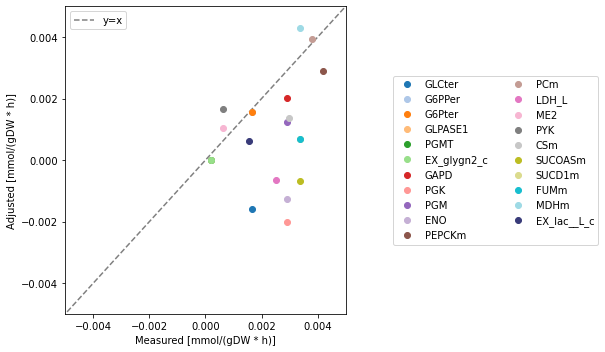

In [24]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux(mmol/(gDW*hr))"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.005,0.005), ylim=(-0.005, 0.005),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

## Create MASS model

In [ ]:
glycolysis = MassModel("Glycolysis", array_type='DataFrame', dtype=np.int64)

## Parameterize MASS model

### Define reactions

In [ ]:
reaction_list = ['HEX1',
                'PGI',
#                 'FBP',
                'PFK',
                'FBA',
                'TPI',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
#                 'PEPtm',
#                 'PEPCKm',
                 'LDH_L',
                'PYK']
#                 'PCm',
                 
#                  'PYRt2m']
new_reaction_list = []
for item in reaction_list: 
    item = core_model.reactions.get_by_id(item)
    new_reaction_list.append(item) 
    
new_reaction_list

# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = core_model.reactions.get_by_id(rid)
    glycolysis.add_reactions([MassReaction(reaction)])
    
## set possible exchanges for in and out?




#### Adding from masspy documentation

In [ ]:
# new_reaction_list
m=["adp_c","amp_c", "atp_c","pi_c","nadh_c","nad_c", "h2o_c", "h_c"]


In [ ]:
# Convert cobra.Reactions to mass.MassReactions
for rid in m:
    met = core_model.metabolites.get_by_id(rid)
    glycolysis.add_metabolites([MassMetabolite(met)])

In [ ]:
glycolysis

In [ ]:
## Adding additional reactions
ADK1 = MassReaction(
    "ADK1",
    name="Adenylate kinase",
    subsystem="Misc.",
    reversible=True)

ADK = ['amp_c','atp_c']
for i in ADK:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:1})
    
ADP =['adp_c']
for i in ADP:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:-2})


In [ ]:
ATPM = MassReaction(
    "ATPM",
    name="ATP maintenance requirement",
    subsystem="Pseudoreaction",
    reversible=False)

ATPM_1 = ['atp_c', 'h2o_c']
ATPM_2= ['adp_c','h_c','pi_c']

for i in ATPM_1:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:-1})
    

for i in ATPM_2:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:1})



In [ ]:
DM_nadh = MassReaction(
    "DM_nadh",
    name="Demand NADH",
    subsystem="Pseudoreaction",
    reversible=False)

DM_nadh_1 = ['nadh_c']
DM_nadh_2= ['nad_c','h_c']

for i in DM_nadh_1:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:-1})
    

for i in DM_nadh_2:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:1})



In [ ]:
# Add new reactions
glycolysis.add_reactions([ADK1, ATPM, DM_nadh])

for reaction in glycolysis.reactions:
    print(reaction)

### View extracted network

In [ ]:
### NEED TO CHECK!!
escher_builder = escher.Builder(
    model=glycolysis,
    map_json=os.path.join(
        maps_dir, ".".join((
            glycolysis.id, "map", "json"))
    ),
    highlight_missing=True)

escher_builder

### Boundary Reactions

In [ ]:
SK_glc__D_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('glc__D_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_glc__D_c.reverse_stoichiometry(inplace=True)

SK_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_amp_c.reverse_stoichiometry(inplace=True)


SK_lac__L_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('lac__L_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pyr_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('pyr_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.06)

SK_h_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=6.30957e-05)

SK_h2o_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h2o_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)



DM_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="demand", subsystem="Pseudoreaction",
    boundary_condition=1)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in glycolysis.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = glycolysis.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

In [ ]:
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c",
    "g3p_c", "13dpg_c", "3pg_c", "2pg_c", "pep_c",
    "pyr_c", "lac__L_c", "nad_c", "nadh_c", "amp_c",
    "adp_c", "atp_c", "pi_c", "h_c", "h2o_c"]

if len(glycolysis.metabolites) == len(new_metabolite_order):
    glycolysis.metabolites = DictList(
        glycolysis.metabolites.get_by_any(new_metabolite_order))
new_reaction_order = [
    "HEX1", "PGI", "PFK", "FBA", "TPI",
    "GAPD", "PGK", "PGM", "ENO", "PYK",
    "LDH_L", "DM_amp_c", "ADK1", "SK_pyr_c",
    "SK_lac__L_c", "ATPM", "DM_nadh", "SK_glc__D_c",
    "SK_amp_c", "SK_h_c", "SK_h2o_c"]

if len(glycolysis.reactions) == len(new_reaction_order):
    glycolysis.reactions = DictList(
        glycolysis.reactions.get_by_any(new_reaction_order))
glycolysis.update_S(array_type="DataFrame", dtype=int)


#### Set fluxes

In [ ]:
minspan_paths = [
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, 1, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
glycolysis.compute_steady_state_fluxes(
    pathways=minspan_paths,
    independent_fluxes={
        SK_glc__D_c: 1.12,
        DM_nadh: .2 * 1.12,
        DM_amp_c: 0.014},
    update_reactions=True)

print("Steady State Fluxes\n-------------------")
for reaction, steady_state_flux in glycolysis.steady_state_fluxes.items():
    print("{0}: {1:.6f}".format(reaction.flux_symbol_str, steady_state_flux))

### Obtain Concentrations


### Set Initial Concentration

In [ ]:
ID_list = ['glc__D_c',
           'g6p_c',
           'f6p_c',
           'fdp_c',
           'dhap_c',
           'g3p_c',
           '13dpg_c',
           '3pg_c',
            '2pg_c',
            'pep_c',
            'pyr_c',
            'lac__L_c',
           'nad_c',
            'nadh_c',
           'amp_c',
           'adp_c',
            'atp_c',
            'pi_c',
            'h_c',          
            'h2o_c']
ID_conc = [10.482807,
           0.14,
           0.127138,
           0.0515,
           8.78E-03,
           0.243,# from textbook
           0.176897,
           
           0.52063,
           0.110561,
           0.31,
           0.48,
           3.261838,
          
           0.0589,
           0.0301,
           0.365,
           1.994952,
            4.727146,
           6.4,
           0.0009,# from textbook
           1# from textbook
            ]

#ID_dic = [{ID_list:ID_conc}]
print("Initial Conditions\n------------------")
for i in range(len(ID_list)):
    item = glycolysis.metabolites.get_by_id(ID_list[i])
    item.ic = ID_conc[i]
    print(item, ':', item.ic)
    



### Keq

#### Set equilibrium constants

In [ ]:
reaction_list = ['HEX1',
                'PGI',
                'PFK',
                'FBA',
                'TPI',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
                 'LDH_L',
                'PYK',
                'ADK1',
                 'ATPM', 
                 'DM_nadh']
rxn_keq = [5000,
0.32,
1000,
0.1,
20.4,
0.005334127,
3200,
12.7,
4.7,
26300,
2220,
1.65,
1000000000,
1000000000]



irr_rxn=["SK_glc__D_c", "SK_amp_c"]

for i in irr_rxn:
    item = glycolysis.reactions.get_by_id(i)
    item.Keq=mass_config.irreversible_Keq
    
    
sink=["SK_lac__L_c","SK_pyr_c","SK_h_c","SK_h2o_c"]
# irr=["SK_glc__D_c","SK_amp_c"] 
for i in sink:
    item=glycolysis.reactions.get_by_id(i)
    item.Keq= 1


for i in range(len(reaction_list)):
    item = glycolysis.reactions.get_by_id(reaction_list[i])
    item.Keq = rxn_keq[i]
#     print(item, ':', item.Keq)
print("Equilibrium Constants\n---------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

### Fluxes

In [ ]:
glycolysis
glycolysis.update_S(array_type="DataFrame", dtype=int)

#### Calculate PERCS

In [ ]:

glycolysis.calculate_PERCs(update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
qcqa_model(glycolysis, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:

# potential conversion factors?
# enzyme modules?


In [ ]:
## flux split through pathways??

In [ ]:
## making enzyme modules??

In [ ]:
## load independent fluxes
# minspan paths, independent fluxes
# steady state fluxes
# print everything

#### Set concentrations

In [ ]:
# Provide initial guesses for a few, setting?
# load, set, print conc values

In [ ]:
## potential optimal solutions? using QP and then comparing

In [ ]:
## calculate PERC's

In [ ]:
## import/merging enzyme modules into model

## Simulate at steady state

In [ ]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

# Export MASS model

In [ ]:
save_json_mass_model(
    mass_model=glycolysis,
    filename=os.path.join(model_dir, glycolysis.id + ".json"))